In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
import os

if IN_COLAB:
    ! pip3 install mne
    ! pip3 install yadisk

    import yadisk

    if not os.path.exists('dataset.zip'):
        url = 'https://disk.yandex.ru/d/hItiy8VK-lk0gQ' 
        y = yadisk.YaDisk()
        y.download_public(url, 'dataset.zip')

        ! unzip dataset.zip

    if not os.path.exists('eegproject'):
        ! unzip eegproject.zip

In [ ]:
import torch
import random
import numpy as np

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(42)

In [ ]:
from eegproject.data.unordered_dataset import UnorderedEEGDataset
from eegproject.data.transforms import scale

In [ ]:
train_dataset = UnorderedEEGDataset(split='train', preprocessed_path='eeg_dataset/train_eeg_dataset.pt', transform=scale)
test_dataset = UnorderedEEGDataset(split='test', preprocessed_path='eeg_dataset/test_eeg_dataset.pt', transform=scale)

In [ ]:
from eegproject.models.cnn_classifier import CNNClassifier
import torch

In [ ]:
model = CNNClassifier()

In [ ]:
train_dataset[:5][0].shape

torch.Size([5, 3000])

In [ ]:
with torch.no_grad():
    print(model(train_dataset[:5][0]).shape)

torch.Size([5, 5])


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()
    cum_loss = 0
    n_objects = 0
    for features, y in tqdm(train_dataloader):
        preds = model(features.to(device)).squeeze()
        loss = criterion(preds, y.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cum_loss += loss.detach().cpu().numpy() * features.shape[0]
        n_objects += features.shape[0]
        
    return cum_loss / n_objects


def predict(model, test_dataloder, criterion, device="cuda:0"):
    model.to(device).eval()
    with torch.no_grad():        
        predicts = torch.tensor([])
        true_values = torch.tensor([])
        cum_loss = 0
        n_objects = 0
        for features, y in tqdm(test_dataloder):
            cur = model(features.to(device)).cpu().squeeze()
            predicts = torch.cat([predicts, np.argmax(cur, axis=1)])
            true_values = torch.cat([true_values, y])
            n_objects += features.shape[0]
            cum_loss += criterion(cur, y).item() * features.shape[0]
        
        return cum_loss / n_objects, predicts, true_values
    

def train(model, train_dataloader, test_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    for epoch in range(n_epochs):
        print('Train')
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        print('Evaluate')
        val_loss, predicted, true = predict(model, test_dataloader, criterion, device)
        if scheduler is not None:
            scheduler.step(val_loss)
            
        accuracy = accuracy_score(predicted, true)
        print('Epoch {}, val loss {:.3f}, train loss {:.3f}, accuracy {:.3f}'\
              .format(epoch + 1, val_loss, train_loss, accuracy))

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [ ]:
model = CNNClassifier()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

In [ ]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, device, 20, scheduler)

Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 1, val loss 0.751, train loss 0.769, accuracy 0.707
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2, val loss 0.652, train loss 0.655, accuracy 0.751
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3, val loss 0.598, train loss 0.620, accuracy 0.771
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4, val loss 0.588, train loss 0.602, accuracy 0.773
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5, val loss 0.600, train loss 0.588, accuracy 0.772
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6, val loss 0.649, train loss 0.577, accuracy 0.742
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7, val loss 0.623, train loss 0.569, accuracy 0.759
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8, val loss 0.592, train loss 0.561, accuracy 0.772
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9, val loss 0.587, train loss 0.541, accuracy 0.773
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10, val loss 0.589, train loss 0.532, accuracy 0.768
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 11, val loss 0.572, train loss 0.527, accuracy 0.780
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 12, val loss 0.599, train loss 0.525, accuracy 0.768
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 13, val loss 0.578, train loss 0.519, accuracy 0.781
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 14, val loss 0.586, train loss 0.516, accuracy 0.770
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Epoch 15, val loss 0.576, train loss 0.513, accuracy 0.782
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 16, val loss 0.581, train loss 0.500, accuracy 0.777
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 17, val loss 0.574, train loss 0.496, accuracy 0.777
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 18, val loss 0.585, train loss 0.492, accuracy 0.772
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.
Epoch 19, val loss 0.587, train loss 0.490, accuracy 0.773
Train


  0%|          | 0/543 [00:00<?, ?it/s]

Evaluate


  0%|          | 0/199 [00:00<?, ?it/s]

Epoch 20, val loss 0.581, train loss 0.482, accuracy 0.775


In [ ]:
torch.save(model, 'cnn_classifier.pt')

In [ ]:
torch.save(model.encoder, 'cnn_encoder.pt')

In [ ]:
loss, y_pred, y_test = predict(model, test_dataloader, criterion, device)

  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
# Assess the results
acc = accuracy_score(y_test, y_pred)
print("Accuracy score: {}".format(acc))

Accuracy score: 0.7747175837391321


In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen kappa score: {}".format(cohen_kappa))

Cohen kappa score: 0.6910230884645139


In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average=None)
f1

array([0.89049376, 0.33085696, 0.82112624, 0.76444444, 0.70035754])

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7704148985701713

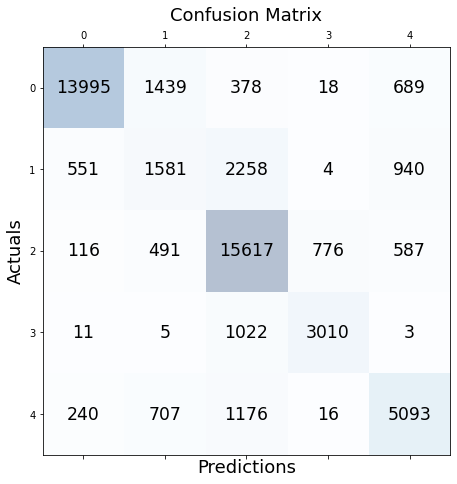

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()